## Import Libraries and Data

# CHOP HERE!!!

# Modeling - predicting affluence based on types of businesses 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
import math


import matplotlib



import os
current_dir = os.getcwd()

from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score

# Styling 
from IPython.display import HTML, display
import tabulate

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## Feature fractions & modeling

In [2]:
# Import our yelp data with cluster and affluent columns

yelp = pd.read_csv('../data/yelp_clean.csv')


In [3]:
yelp.head()

,Unnamed: 0,name,review_count,rating,price,cat1,zip_code,nyc,borough,cluster,is_affluent
0,0,Com Tam Ninh Kieu,379,4.0,2,vietnamese,10468,True,Bronx,12,0
1,1,Antonio's Trattoria,773,4.5,2,italian,10458,True,Bronx,12,0
2,2,Bronx Alehouse,749,4.0,2,tradamerican,10463,True,Bronx,62,0
3,4,The Bronx Public,443,4.0,2,sportsbars,10463,True,Bronx,62,0
4,5,Trattoria Zero Otto Nove,749,4.0,2,italian,10458,True,Bronx,12,0


In [4]:
# Function to create percent features. Take in a data frame, df_feature, collect the categories in the group_col
# identify the features in feature_col and give a percent of the feature for the group.
# Use: for cluster (group_col) find the fraction of a feature in the feature_col
def class_fraction_feature(df_feature, group_col, feature_col):
    # identify unique groups and the unique features
    groups   = df_feature[group_col].unique().tolist()
    features = df_feature[feature_col].unique().tolist()    
    
    # Create a dictionary to store the groups. Iterate through the groups and collect counts for the features
    data = []
    for g in groups:
        # empty dictionary to fill up the group
        g_dict = {'group_col':g}
        
        for f in features:
            g_dict[f] = df_feature[(df_feature[group_col]==g)&(df_feature[feature_col]==f)][feature_col].count()
    
        # append the dictionary entry for a group to the list of groups
        data.append(g_dict)
        
    data = pd.DataFrame(data)
    
    # Create total by row and create fraction on each column
    data['total'] = data[features].sum(axis = 1)
    for f in features:
        data[ str(f) + '_fraction'] = data[f]/data['total']
    
    return data

In [5]:

# Calculating the percentages for each business type
cluster_price_fraction = class_fraction_feature(yelp,'cluster','price')
cluster_type_fraction = class_fraction_feature(yelp,'cluster','cat1')


In [6]:
cluster_is_affluent = yelp[['cluster', 'is_affluent']]
cluster_is_affluent = cluster_is_affluent.drop_duplicates(keep ='first')


In [7]:
# Join the fractions together to create a combined set for the clusters
cluster_fraction = cluster_price_fraction.merge(cluster_type_fraction, on = 'group_col', suffixes = ('_x','_y'))

# join in affluence
cluster_fraction = cluster_fraction.rename(columns={'group_col':'cluster'})
cluster_fraction = cluster_is_affluent.merge(cluster_fraction, on = 'cluster')

cluster_fraction.head()


,cluster,is_affluent,2,1,3,4,total_x,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese,italian,tradamerican,sportsbars,desserts,mexican,coffee,bars,breakfast_brunch,comfortfood,delis,pizza,bakeries,japanese,venezuelan,catering,greek,burgers,meats,beergardens,newamerican,tapasmallplates,foodtrucks,cuban,spanish,diners,coffeeroasteries,irish,lounges,wine_bars,latin,modern_european,cafes,bbq,drugstores,halal,thai,icecream,juicebars,asianfusion,indpak,seafood,chinese,pubs,bagels,sushi,dominican,caribbean,grocery,pakistani,divebars,hotdogs,donuts,tex-mex,african,mediterranean,poolhalls,kosher,chicken_wings,restaurants,salvadoran,vegetarian,cigarbars,buffets,salad,convenience,danceclubs,cafeteria,sandwiches,tacos,cantonese,foodstands,steak,markets,moroccan,southern,french,argentine,laundromat,szechuan,venues,hotdog,korean,cheese,bowling,streetvendors,gastropubs,chocolate,filipino,noodles,macarons,tea,food_court,waffles,acaibowls,dimsum,bubbletea,champagne_bars,cocktailbars,soup,landmarks,nonprofit,vegan,ramen,ethiopian,tapas,mideastern,falafel,fishnchips,soulfood,gelato,bookstores,hookah_bars,poke,customcakes,tobaccoshops,hotpot,turkish,shanghainese,pastashops,russian,uzbek,peruvian,taiwanese,cajun,polish,gourmet,malaysian,chickenshop,afghani,karaoke,ukrainian,irish_pubs,georgian,german,srilankan,candy,healthmarkets,musicvideo,colombian,magicians,pretzels,comedyclubs,beer_and_wine,speakeasies,shavedice,cupcakes,brazilian,himalayan,beerbar,tikibars,belgian,musicvenues,teppanyaki,izakaya,persian,japacurry,butcher,supperclubs,arcades,whiskeybars,portuguese,australian,publicmarkets,gaybars,mags,cheesesteaks,hawaiian,artmuseums,scandinavian,indonesian,hair,jazzandblues,cambodian,british,seafoodmarkets,lebanese,boating,panasian,gluten_free,armenian,themedcafes,empanadas,hkcafe,cakeshop,tours,hobbyshops,basque,fondue,pianobars,sports_clubs,golflessons,boxing,museums,creperies,fooddeliveryservices,intlgrocery,barbers,tuscan,eventplanning,newmexican,movietheaters,laotian,mongolian,wraps,hungarian,trinidadian,haitian,puertorican,festivals,servicestations,theater,kebab,austrian,distilleries,breweries,skate_parks,czech,shoppingcenters,southafrican,petstore,sharedofficespaces,popuprestaurants,hotels,egyptian,tattoo,organic_stores,vinyl_records,senegalese,galleries,bangladeshi,brasseries,sportswear,vapeshops,florists,cookingclasses,kitchenandbath,culturalcenter,sportgoods,...,coffee_fraction,bars_fraction,breakfast_brunch_fraction,comfortfood_fraction,delis_fraction,pizza_fraction,bakeries_fraction,japanese_fraction,venezuelan_fraction,catering_fraction,greek_fraction,burgers_fraction,meats_fraction,beergardens_fraction,newamerican_fraction,tapasmallplates_fraction,foodtrucks_fraction,cuban_fraction,spanish_fraction,diners_fraction,coffeeroasteries_fraction,irish_fraction,lounges_fraction,wine_bars_fraction,latin_fraction,modern_european_fraction,cafes_fraction,bbq_fraction,drugstores_fraction,halal_fraction,thai_fraction,icecream_fraction,juicebars_fraction,asianfusion_fraction,indpak_fraction,seafood_fraction,chinese_fraction,pubs_fraction,bagels_fraction,sushi_fraction,dominican_fraction,caribbean_fraction,grocery_fraction,pakistani_fraction,divebars_fraction,hotdogs_fraction,donuts_fraction,tex-mex_fraction,african_fraction,mediterranean_fraction,poolhalls_fraction,kosher_fraction,chicken_wings_fraction,restaurants_fraction,salvadoran_fraction,vegetarian_fraction,cigarbars_fraction,buffets_fraction,salad_fraction,convenience_fraction,danceclubs_fraction,cafeteria_fraction,sandwiches_fraction,tacos_fraction,cantonese_fraction,foodstands_fraction,steak_fraction,markets_fraction,moroccan_fraction,southern_fraction,french_fraction,argentine_fraction,laundromat_fraction,szechuan_fraction,venues_fraction,hotdog_fraction,korean_fraction,cheese_fraction,bowling_fraction,streetvendors_fraction,gastropubs_fraction,chocolate_fraction,filipino_fraction,noodles_fraction,macarons_fraction,tea_fraction,food_court_fraction,waffles_fraction,acaibowls_fra

In [8]:
cluster_fraction = cluster_fraction.drop(columns = ['cluster'])

In [9]:
# Checking the sums for each are the same
cluster_fraction[['total_x', 'total_y']]

,total_x,total_y
0,209,209
1,144,144
2,145,145
3,91,91
4,151,151
5,378,378
6,316,316
7,421,421
8,368,368
9,544,544


In [10]:
list(cluster_fraction.columns) # checking out the columns


['is_affluent',
 2,
 1,
 3,
 4,
 'total_x',
 '2_fraction',
 '1_fraction',
 '3_fraction',
 '4_fraction',
 'vietnamese',
 'italian',
 'tradamerican',
 'sportsbars',
 'desserts',
 'mexican',
 'coffee',
 'bars',
 'breakfast_brunch',
 'comfortfood',
 'delis',
 'pizza',
 'bakeries',
 'japanese',
 'venezuelan',
 'catering',
 'greek',
 'burgers',
 'meats',
 'beergardens',
 'newamerican',
 'tapasmallplates',
 'foodtrucks',
 'cuban',
 'spanish',
 'diners',
 'coffeeroasteries',
 'irish',
 'lounges',
 'wine_bars',
 'latin',
 'modern_european',
 'cafes',
 'bbq',
 'drugstores',
 'halal',
 'thai',
 'icecream',
 'juicebars',
 'asianfusion',
 'indpak',
 'seafood',
 'chinese',
 'pubs',
 'bagels',
 'sushi',
 'dominican',
 'caribbean',
 'grocery',
 'pakistani',
 'divebars',
 'hotdogs',
 'donuts',
 'tex-mex',
 'african',
 'mediterranean',
 'poolhalls',
 'kosher',
 'chicken_wings',
 'restaurants',
 'salvadoran',
 'vegetarian',
 'cigarbars',
 'buffets',
 'salad',
 'convenience',
 'danceclubs',
 'cafeteria',


In [11]:
# Adding two engineered columns based on dollar sign groupings
cluster_fraction['1_2_fraction'] = cluster_fraction['1_fraction'] + cluster_fraction['2_fraction']
cluster_fraction['3_4_fraction'] = cluster_fraction['3_fraction'] + cluster_fraction['4_fraction']
cluster_fraction.columns

Index([             'is_affluent',                          2,
                                1,                          3,
                                4,                  'total_x',
                     '2_fraction',               '1_fraction',
                     '3_fraction',               '4_fraction',
       ...
           'singaporean_fraction',         'diyfood_fraction',
       'kids_activities_fraction',        'shopping_fraction',
        'cookingschools_fraction',         'burmese_fraction',
              'sicilian_fraction',   'farmersmarket_fraction',
                   '1_2_fraction',             '3_4_fraction'],
      dtype='object', length=525)

In [12]:
# Removing all the columns that are based on count, vs %
cluster_fraction = cluster_fraction.drop(columns = [2, 1, 3, 4,  'vietnamese',
 'italian',
 'tradamerican',
 'sportsbars',
 'desserts',
 'mexican',
 'coffee',
 'bars',
 'breakfast_brunch',
 'comfortfood',
 'delis',
 'pizza',
 'bakeries',
 'japanese',
 'venezuelan',
 'catering',
 'greek',
 'burgers',
 'meats',
 'beergardens',
 'newamerican',
 'tapasmallplates',
 'foodtrucks',
 'cuban',
 'spanish',
 'diners',
 'coffeeroasteries',
 'irish',
 'lounges',
 'wine_bars',
 'latin',
 'modern_european',
 'cafes',
 'bbq',
 'drugstores',
 'halal',
 'thai',
 'icecream',
 'juicebars',
 'asianfusion',
 'indpak',
 'seafood',
 'chinese',
 'pubs',
 'bagels',
 'sushi',
 'dominican',
 'caribbean',
 'grocery',
 'pakistani',
 'divebars',
 'hotdogs',
 'donuts',
 'tex-mex',
 'african',
 'mediterranean',
 'poolhalls',
 'kosher',
 'chicken_wings',
 'restaurants',
 'salvadoran',
 'vegetarian',
 'cigarbars',
 'buffets',
 'salad',
 'convenience',
 'danceclubs',
 'cafeteria',
 'sandwiches',
 'tacos',
 'cantonese',
 'foodstands',
 'steak',
 'markets',
 'moroccan',
 'southern',
 'french',
 'argentine',
 'laundromat',
 'szechuan',
 'venues',
 'hotdog',
 'korean',
 'cheese',
 'bowling',
 'streetvendors',
 'gastropubs',
 'chocolate',
 'filipino',
 'noodles',
 'macarons',
 'tea',
 'food_court',
 'waffles',
 'acaibowls',
 'dimsum',
 'bubbletea',
 'champagne_bars',
 'cocktailbars',
 'soup',
 'landmarks',
 'nonprofit',
 'vegan',
 'ramen',
 'ethiopian',
 'tapas',
 'mideastern',
 'falafel',
 'fishnchips',
 'soulfood',
 'gelato',
 'bookstores',
 'hookah_bars',
 'poke',
 'customcakes',
 'tobaccoshops',
 'hotpot',
 'turkish',
 'shanghainese',
 'pastashops',
 'russian',
 'uzbek',
 'peruvian',
 'taiwanese',
 'cajun',
 'polish',
 'gourmet',
 'malaysian',
 'chickenshop',
 'afghani',
 'karaoke',
 'ukrainian',
 'irish_pubs',
 'georgian',
 'german',
 'srilankan',
 'candy',
 'healthmarkets',
 'musicvideo',
 'colombian',
 'magicians',
 'pretzels',
 'comedyclubs',
 'beer_and_wine',
 'speakeasies',
 'shavedice',
 'cupcakes',
 'brazilian',
 'himalayan',
 'beerbar',
 'tikibars',
 'belgian',
 'musicvenues',
 'teppanyaki',
 'izakaya',
 'persian',
 'japacurry',
 'butcher',
 'supperclubs',
 'arcades',
 'whiskeybars',
 'portuguese',
 'australian',
 'publicmarkets',
 'gaybars',
 'mags',
 'cheesesteaks',
 'hawaiian',
 'artmuseums',
 'scandinavian',
 'indonesian',
 'hair',
 'jazzandblues',
 'cambodian',
 'british',
 'seafoodmarkets',
 'lebanese',
 'boating',
 'panasian',
 'gluten_free',
 'armenian',
 'themedcafes',
 'empanadas',
 'hkcafe',
 'cakeshop',
 'tours',
 'hobbyshops',
 'basque',
 'fondue',
 'pianobars',
 'sports_clubs',
 'golflessons',
 'boxing',
 'museums',
 'creperies',
 'fooddeliveryservices',
 'intlgrocery',
 'barbers',
 'tuscan',
 'eventplanning',
 'newmexican',
 'movietheaters',
 'laotian',
 'mongolian',
 'wraps',
 'hungarian',
 'trinidadian',
 'haitian',
 'puertorican',
 'festivals',
 'servicestations',
 'theater',
 'kebab',
 'austrian',
 'distilleries',
 'breweries',
 'skate_parks',
 'czech',
 'shoppingcenters',
 'southafrican',
 'petstore',
 'sharedofficespaces',
 'popuprestaurants',
 'hotels',
 'egyptian',
 'tattoo',
 'organic_stores',
 'vinyl_records',
 'senegalese',
 'galleries',
 'bangladeshi',
 'brasseries',
 'sportswear',
 'vapeshops',
 'florists',
 'cookingclasses',
 'kitchenandbath',
 'culturalcenter',
 'sportgoods',
 'nightlife',
 'eatertainment',
 'food',
 'herbsandspices',
 'localservices',
 'airportlounges',
 'golf',
 'giftshops',
 'spas',
 'singaporean',
 'diyfood',
 'kids_activities',
 'shopping',
 'cookingschools',
 'burmese',
 'sicilian',
 'farmersmarket', 'restaurants_fraction',
 'total_y', 'total_x'])
cluster_fraction.head(10)

,is_affluent,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese_fraction,italian_fraction,tradamerican_fraction,sportsbars_fraction,desserts_fraction,mexican_fraction,coffee_fraction,bars_fraction,breakfast_brunch_fraction,comfortfood_fraction,delis_fraction,pizza_fraction,bakeries_fraction,japanese_fraction,venezuelan_fraction,catering_fraction,greek_fraction,burgers_fraction,meats_fraction,beergardens_fraction,newamerican_fraction,tapasmallplates_fraction,foodtrucks_fraction,cuban_fraction,spanish_fraction,diners_fraction,coffeeroasteries_fraction,irish_fraction,lounges_fraction,wine_bars_fraction,latin_fraction,modern_european_fraction,cafes_fraction,bbq_fraction,drugstores_fraction,halal_fraction,thai_fraction,icecream_fraction,juicebars_fraction,asianfusion_fraction,indpak_fraction,seafood_fraction,chinese_fraction,pubs_fraction,bagels_fraction,sushi_fraction,dominican_fraction,caribbean_fraction,grocery_fraction,pakistani_fraction,divebars_fraction,hotdogs_fraction,donuts_fraction,tex-mex_fraction,african_fraction,mediterranean_fraction,poolhalls_fraction,kosher_fraction,chicken_wings_fraction,salvadoran_fraction,vegetarian_fraction,cigarbars_fraction,buffets_fraction,salad_fraction,convenience_fraction,danceclubs_fraction,cafeteria_fraction,sandwiches_fraction,tacos_fraction,cantonese_fraction,foodstands_fraction,steak_fraction,markets_fraction,moroccan_fraction,southern_fraction,french_fraction,argentine_fraction,laundromat_fraction,szechuan_fraction,venues_fraction,hotdog_fraction,korean_fraction,cheese_fraction,bowling_fraction,streetvendors_fraction,gastropubs_fraction,chocolate_fraction,filipino_fraction,noodles_fraction,macarons_fraction,tea_fraction,food_court_fraction,waffles_fraction,acaibowls_fraction,dimsum_fraction,bubbletea_fraction,champagne_bars_fraction,cocktailbars_fraction,soup_fraction,landmarks_fraction,nonprofit_fraction,vegan_fraction,ramen_fraction,ethiopian_fraction,tapas_fraction,mideastern_fraction,falafel_fraction,fishnchips_fraction,soulfood_fraction,gelato_fraction,bookstores_fraction,hookah_bars_fraction,poke_fraction,customcakes_fraction,tobaccoshops_fraction,hotpot_fraction,turkish_fraction,shanghainese_fraction,pastashops_fraction,russian_fraction,uzbek_fraction,peruvian_fraction,taiwanese_fraction,cajun_fraction,polish_fraction,gourmet_fraction,malaysian_fraction,chickenshop_fraction,afghani_fraction,karaoke_fraction,ukrainian_fraction,irish_pubs_fraction,georgian_fraction,german_fraction,srilankan_fraction,candy_fraction,healthmarkets_fraction,musicvideo_fraction,colombian_fraction,magicians_fraction,pretzels_fraction,comedyclubs_fraction,beer_and_wine_fraction,speakeasies_fraction,shavedice_fraction,cupcakes_fraction,brazilian_fraction,himalayan_fraction,beerbar_fraction,tikibars_fraction,belgian_fraction,musicvenues_fraction,teppanyaki_fraction,izakaya_fraction,persian_fraction,japacurry_fraction,butcher_fraction,supperclubs_fraction,arcades_fraction,whiskeybars_fraction,portuguese_fraction,australian_fraction,publicmarkets_fraction,gaybars_fraction,mags_fraction,cheesesteaks_fraction,hawaiian_fraction,artmuseums_fraction,scandinavian_fraction,indonesian_fraction,hair_fraction,jazzandblues_fraction,cambodian_fraction,british_fraction,seafoodmarkets_fraction,lebanese_fraction,boating_fraction,panasian_fraction,gluten_free_fraction,armenian_fraction,themedcafes_fraction,empanadas_fraction,hkcafe_fraction,cakeshop_fraction,tours_fraction,hobbyshops_fraction,basque_fraction,fondue_fraction,pianobars_fraction,sports_clubs_fraction,golflessons_fraction,boxing_fraction,museums_fraction,creperies_fraction,fooddeliveryservices_fraction,intlgrocery_fraction,barbers_fraction,tuscan_fraction,eventplanning_fraction,newmexican_fraction,movietheaters_fraction,laotian_fraction,mongolian_fraction,wraps_fraction,hungarian_fraction,trinidadian_fraction,haitian_fraction,puertorican_fraction,festivals_fraction,servicestations_fraction,theater_fraction,kebab_fraction,austrian_fraction,distilleries_fra

In [13]:
# This is our targeted dataframe - with all possible % categories
cluster_fraction.head(10)


,is_affluent,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese_fraction,italian_fraction,tradamerican_fraction,sportsbars_fraction,desserts_fraction,mexican_fraction,coffee_fraction,bars_fraction,breakfast_brunch_fraction,comfortfood_fraction,delis_fraction,pizza_fraction,bakeries_fraction,japanese_fraction,venezuelan_fraction,catering_fraction,greek_fraction,burgers_fraction,meats_fraction,beergardens_fraction,newamerican_fraction,tapasmallplates_fraction,foodtrucks_fraction,cuban_fraction,spanish_fraction,diners_fraction,coffeeroasteries_fraction,irish_fraction,lounges_fraction,wine_bars_fraction,latin_fraction,modern_european_fraction,cafes_fraction,bbq_fraction,drugstores_fraction,halal_fraction,thai_fraction,icecream_fraction,juicebars_fraction,asianfusion_fraction,indpak_fraction,seafood_fraction,chinese_fraction,pubs_fraction,bagels_fraction,sushi_fraction,dominican_fraction,caribbean_fraction,grocery_fraction,pakistani_fraction,divebars_fraction,hotdogs_fraction,donuts_fraction,tex-mex_fraction,african_fraction,mediterranean_fraction,poolhalls_fraction,kosher_fraction,chicken_wings_fraction,salvadoran_fraction,vegetarian_fraction,cigarbars_fraction,buffets_fraction,salad_fraction,convenience_fraction,danceclubs_fraction,cafeteria_fraction,sandwiches_fraction,tacos_fraction,cantonese_fraction,foodstands_fraction,steak_fraction,markets_fraction,moroccan_fraction,southern_fraction,french_fraction,argentine_fraction,laundromat_fraction,szechuan_fraction,venues_fraction,hotdog_fraction,korean_fraction,cheese_fraction,bowling_fraction,streetvendors_fraction,gastropubs_fraction,chocolate_fraction,filipino_fraction,noodles_fraction,macarons_fraction,tea_fraction,food_court_fraction,waffles_fraction,acaibowls_fraction,dimsum_fraction,bubbletea_fraction,champagne_bars_fraction,cocktailbars_fraction,soup_fraction,landmarks_fraction,nonprofit_fraction,vegan_fraction,ramen_fraction,ethiopian_fraction,tapas_fraction,mideastern_fraction,falafel_fraction,fishnchips_fraction,soulfood_fraction,gelato_fraction,bookstores_fraction,hookah_bars_fraction,poke_fraction,customcakes_fraction,tobaccoshops_fraction,hotpot_fraction,turkish_fraction,shanghainese_fraction,pastashops_fraction,russian_fraction,uzbek_fraction,peruvian_fraction,taiwanese_fraction,cajun_fraction,polish_fraction,gourmet_fraction,malaysian_fraction,chickenshop_fraction,afghani_fraction,karaoke_fraction,ukrainian_fraction,irish_pubs_fraction,georgian_fraction,german_fraction,srilankan_fraction,candy_fraction,healthmarkets_fraction,musicvideo_fraction,colombian_fraction,magicians_fraction,pretzels_fraction,comedyclubs_fraction,beer_and_wine_fraction,speakeasies_fraction,shavedice_fraction,cupcakes_fraction,brazilian_fraction,himalayan_fraction,beerbar_fraction,tikibars_fraction,belgian_fraction,musicvenues_fraction,teppanyaki_fraction,izakaya_fraction,persian_fraction,japacurry_fraction,butcher_fraction,supperclubs_fraction,arcades_fraction,whiskeybars_fraction,portuguese_fraction,australian_fraction,publicmarkets_fraction,gaybars_fraction,mags_fraction,cheesesteaks_fraction,hawaiian_fraction,artmuseums_fraction,scandinavian_fraction,indonesian_fraction,hair_fraction,jazzandblues_fraction,cambodian_fraction,british_fraction,seafoodmarkets_fraction,lebanese_fraction,boating_fraction,panasian_fraction,gluten_free_fraction,armenian_fraction,themedcafes_fraction,empanadas_fraction,hkcafe_fraction,cakeshop_fraction,tours_fraction,hobbyshops_fraction,basque_fraction,fondue_fraction,pianobars_fraction,sports_clubs_fraction,golflessons_fraction,boxing_fraction,museums_fraction,creperies_fraction,fooddeliveryservices_fraction,intlgrocery_fraction,barbers_fraction,tuscan_fraction,eventplanning_fraction,newmexican_fraction,movietheaters_fraction,laotian_fraction,mongolian_fraction,wraps_fraction,hungarian_fraction,trinidadian_fraction,haitian_fraction,puertorican_fraction,festivals_fraction,servicestations_fraction,theater_fraction,kebab_fraction,austrian_fraction,distilleries_fra

In [14]:
cluster_fraction.shape

(79, 262)

# Model Preparation

In [15]:
target = 'is_affluent'
X = cluster_fraction.drop(columns=target)
y = cluster_fraction[target]

# Train, Test Split
1. Since our dataset is large enough, we will reserve 20% of the data as test data. 
2. We will use 'stratify = y' to ensure the classes of y are balanced in both train and test.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

### Check distributions of Y to see if we have balanced classes

In [17]:
# Check distribution of y, to see if y has unbalanced classes
y.value_counts(normalize=True)

0    0.531646
1    0.468354
Name: is_affluent, dtype: float64

In [18]:
# Check distribution of y_train
y_train.value_counts(normalize=True)

0    0.52381
1    0.47619
Name: is_affluent, dtype: float64

In [19]:
# Check distribution of y_test
y_test.value_counts(normalize=True)

0    0.5625
1    0.4375
Name: is_affluent, dtype: float64

# Modeling: First Round

- In the modeling process, I will first present my baseline model.  
- I will then develop 4 major categories of models: Naive Bayes Models (Multinomial and Gaussian), Logistic Regression Models, KNN model, and SVM. 
- Based on the grid search's cross validation score, I will then fine tune the hyper-parameters for each model to achieve the optimal result. 

## Evaluation Metric

- Before I go into developing the models, I will briefly discuss the evaluation metric: AUC ROC. 

- "ROC (Receiver Operating Characteristic) is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes"[(reference)](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). The higher the ROC, and the better it seperates the two classes r/startrek and r/StarWars. The ROC curve is plotted with True Positive Rate on y-aixs, against the False Positive Rate on the x-axis.

- AUC (Area Under the Curve) measures the entire two-dimensional area underneath the entire ROC curve. The closer AUC to 1, the better the model.

- I choose AUC ROC since I aim to find the optimal model that can separate the two classes r/startrek and r/StarWars really well. 

- I will also consider the amount of time each model take to fit. If two models have similar AUC ROC scores, the one that runs faster will be the model we choose. 

##  Baseline Model

In [20]:
y_test.value_counts(normalize=True)[0]

0.5625

## Logistic Regression

In [21]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [22]:
# instantiate & fit the logistic classification model
log_reg = LogisticRegression(max_iter = 400, C = 0.001, penalty = 'l2')
log_reg.fit(X_train_sc, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
print(f'Logistic Regression Train Score:                        {log_reg.score(X_train_sc, y_train):.3f}')
print(f'Logistic Regression Test Score:                         {log_reg.score(X_test_sc, y_test):.3f}')


Logistic Regression Train Score:                        0.889
Logistic Regression Test Score:                         0.688


In [24]:
log_coefficients = log_reg.coef_
log_coefficients

array([[ 9.53785662e-03, -9.41235967e-03,  4.38429166e-03,
         8.74078781e-03,  5.85377286e-03,  3.58387743e-03,
        -2.62011370e-03,  1.88757719e-03,  4.33981457e-03,
         4.93028059e-04,  1.16956074e-02,  5.28006264e-03,
         6.73133533e-04, -6.54830244e-03,  1.14228335e-03,
        -1.22671683e-02,  1.53735005e-03, -1.44001313e-03,
        -1.07755449e-03,  1.82577144e-03,  2.53485969e-03,
        -3.02561373e-03, -1.10519202e-03,  2.08480719e-03,
         6.90017275e-03,  3.00799097e-03, -3.26553047e-04,
         5.54555294e-03, -6.78420234e-03, -8.92281593e-03,
         6.27406320e-03, -5.58540092e-03,  3.16382440e-03,
         1.13960064e-02, -5.25368530e-03, -1.16607201e-03,
         1.17913961e-02, -9.44105881e-04, -1.86675990e-03,
        -4.45836676e-04,  8.11405703e-03, -4.83313131e-03,
         2.67636217e-03,  3.53282527e-04, -6.16297833e-04,
        -3.93037214e-03, -6.41346978e-03, -7.83435456e-04,
        -5.23419392e-03,  6.16823489e-03, -4.14692658e-0

In [25]:
log_coefficients = log_coefficients.ravel()

In [26]:
log_coefficients
log_coefficients.shape

(261,)

In [27]:
log_features_names  = X_train.columns

In [28]:
log_test_coef = pd.DataFrame({'coef' : log_coefficients, 'feature_name' : log_features_names})

In [29]:
log_test_coef.sort_values(by = 'coef', ascending = False)

,coef,feature_name
79,0.015138,french_fraction
101,0.013433,cocktailbars_fraction
106,0.013159,ramen_fraction
152,0.013051,beerbar_fraction
36,0.011791,cafes_fraction
10,0.011696,coffee_fraction
33,0.011396,wine_bars_fraction
155,0.010602,musicvenues_fraction
64,0.010254,vegetarian_fraction
89,0.009604,gastropubs_fraction


In [30]:
# instantiate & fit the KNN model
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(X_train_sc, y_train)

# instantiate & fit the Decision Tree model
dtt_class = DecisionTreeClassifier()
dtt_class.fit(X_train_sc, y_train)

# instantiate & fit the Bagging model
bag_class = BaggingClassifier()
bag_class.fit(X_train_sc, y_train)

# instantiate & fit random forest model
rf_class = RandomForestClassifier(n_estimators = 100)
rf_class.fit(X_train_sc, y_train)

# instantiate & fit Adaboost model
ada_class = AdaBoostClassifier()
ada_class.fit(X_train_sc, y_train)

# instantiate & fit support vector classifier
svc_class = svm.SVC(gamma = 'scale')
svc_class.fit(X_train_sc, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
# Evaluate Training Scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {log_reg.score(X_train_sc, y_train):.3f}')
print(f'K-Nearest Neighbors Classification:           {knn_class.score(X_train_sc, y_train):.3f}')
print(f'Decision Tree Classification:                 {dtt_class.score(X_train_sc, y_train):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {bag_class.score(X_train_sc, y_train):.3f}')
print(f'Random Forest Classification:                 {rf_class.score(X_train_sc, y_train):.3f}')
print(f'Adaboost Classification:                      {ada_class.score(X_train_sc, y_train):.3f}')
print(f'Support Vector Classification:                {svc_class.score(X_train_sc, y_train):.3f}')

Training Scores:
Logistic Regression:                          0.889
K-Nearest Neighbors Classification:           0.651
Decision Tree Classification:                 1.000
Set of Bagged Decision Trees Classification:  0.984
Random Forest Classification:                 1.000
Adaboost Classification:                      1.000
Support Vector Classification:                1.000


In [32]:
# Evaluate Testing Scores for each Classification Model
print('Testing Scores:')
print(f'Logistic Regression:                          {log_reg.score(X_test_sc, y_test):.3f}')
print(f'K-Nearest Neighbors Classification:           {knn_class.score(X_test_sc, y_test):.3f}')
print(f'Decision Tree Classification:                 {dtt_class.score(X_test_sc, y_test):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {bag_class.score(X_test_sc, y_test):.3f}')
print(f'Random Forest Classification:                 {rf_class.score(X_test_sc, y_test):.3f}')
print(f'Adaboost Classification:                      {ada_class.score(X_test_sc, y_test):.3f}')
print(f'Support Vector Classification:                {svc_class.score(X_test_sc, y_test):.3f}')

Testing Scores:
Logistic Regression:                          0.688
K-Nearest Neighbors Classification:           0.750
Decision Tree Classification:                 0.750
Set of Bagged Decision Trees Classification:  0.812
Random Forest Classification:                 0.875
Adaboost Classification:                      0.812
Support Vector Classification:                0.688


In [33]:
# Evaluate Cross Validation Scores for each Classification Model
print('Cross Validation Scores:')
print(f'Logistic Regression:                          {cross_val_score(log_reg, X, y, cv = 3).mean():.3f}')
print(f'K-Nearest Neighbors Classification:           {cross_val_score(knn_class, X, y, cv = 3).mean():.3f}')
print(f'Decision Tree Classification:                 {cross_val_score(dtt_class, X, y, cv = 3).mean():.3f}')
print(f'Set of Bagged Decision Trees Classification:  {cross_val_score(bag_class, X, y, cv = 3).mean():.3f}')
print(f'Random Forest Classification:                 {cross_val_score(rf_class, X, y, cv = 3).mean():.3f}')
print(f'Adaboost Classification:                      {cross_val_score(ada_class, X, y, cv = 3).mean():.3f}')
print(f'Support Vector Classification:                {cross_val_score(svc_class, X, y, cv = 3).mean():.3f}')

Cross Validation Scores:
Logistic Regression:                          0.532
K-Nearest Neighbors Classification:           0.657
Decision Tree Classification:                 0.772
Set of Bagged Decision Trees Classification:  0.783
Random Forest Classification:                 0.796
Adaboost Classification:                      0.758
Support Vector Classification:                0.669


### Additional modeling

In [95]:
pipe = Pipeline(steps=[ 
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_params ={
    'lr__C': [0.0001, .001, .01],
    'lr__penalty' : ['l1', 'l2']
    }

gs_lr = GridSearchCV(pipe, 
                     pipe_params, 
                     cv=3,
                     scoring='roc_auc')


In [96]:
gs_lr.fit(X_train_sc, y_train);

In [97]:
# Check the optimal params
gs_lr.best_params_

{'lr__C': 0.0001, 'lr__penalty': 'l2'}

In [98]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=0.0001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [99]:
# Train score
gs_lr.score(X_train_sc, y_train)

0.9676767676767677

In [101]:
# Test score
gs_lr.score(X_test_sc, y_test)

0.8571428571428572

In [107]:
# Cross val score on the whole dataset 
cross_val_score(gs_lr.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7556471306471306

In [102]:
coef_lr_gs = np.array((gs_lr.best_estimator_.named_steps['lr']).coef_).tolist()[0]


In [103]:
names = X_train.columns

In [104]:
gs_lr_betas = list(zip(names, coef_lr_gs))
gs_lr_betas

[('2_fraction', 0.0012230844760381103),
 ('1_fraction', -0.001228045936740203),
 ('3_fraction', 0.0006203633287417818),
 ('4_fraction', 0.0011209032097975848),
 ('vietnamese_fraction', 0.0007156095534733232),
 ('italian_fraction', 0.0004883556411697931),
 ('tradamerican_fraction', -0.0002534348691478425),
 ('sportsbars_fraction', 0.00021263000557246347),
 ('desserts_fraction', 0.0005194197663295164),
 ('mexican_fraction', 1.84915740765413e-05),
 ('coffee_fraction', 0.001387715315675714),
 ('bars_fraction', 0.0006582871485072924),
 ('breakfast_brunch_fraction', 0.00015550501992543634),
 ('comfortfood_fraction', -0.0007373143580829561),
 ('delis_fraction', 0.00010547226910196979),
 ('pizza_fraction', -0.0014760181815191443),
 ('bakeries_fraction', 0.00010906043036142844),
 ('japanese_fraction', -4.406155101982851e-05),
 ('venezuelan_fraction', -9.443909329186121e-05),
 ('catering_fraction', 0.00018030611020809),
 ('greek_fraction', 0.00032943634158429634),
 ('burgers_fraction', -0.000418

In [105]:
# Create final dataframe of words with their corresponding coefficients
gs_lr_coefs = pd.DataFrame(gs_lr_betas).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [106]:
gs_lr_coefs[gs_lr_coefs['coef'] != 0] 

,word,coef
79,french_fraction,1.829084e-03
106,ramen_fraction,1.608382e-03
101,cocktailbars_fraction,1.592869e-03
152,beerbar_fraction,1.492697e-03
33,wine_bars_fraction,1.417876e-03
36,cafes_fraction,1.403223e-03
10,coffee_fraction,1.387715e-03
155,musicvenues_fraction,1.314971e-03
0,2_fraction,1.223084e-03
64,vegetarian_fraction,1.212353e-03


## KNN model

In [112]:
# Pipe line: CountVectorizer() + LogisticRegression
pipe_knn = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn ={
    'knn__n_neighbors' : [5, 10, 15, 20]
    
}

gs_knn = GridSearchCV(pipe_knn, 
                      pipe_params_knn, 
                      cv=3,
                      scoring='roc_auc')

In [113]:
gs_knn.fit(X_train, y_train);

In [114]:
# Check the optimal params
gs_knn.best_params_

{'knn__n_neighbors': 10}

In [115]:
# Train score
gs_knn.score(X_train, y_train)

0.8914141414141414

In [116]:
# Test score
gs_knn.score(X_test, y_test)

0.8333333333333334

In [117]:
# Cross val score on the whole dataset 
cross_val_score(gs_knn.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7304639804639804

In [118]:
#coef_knn_gs = np.array((gs_knn.best_estimator_.named_steps['knn']).coef_).tolist()[0]

## Trees

### Decision Tree

In [119]:
pipe_dt = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('dt', DecisionTreeClassifier(random_state=42))
])

pipe_params_dt = {
    'dt__max_depth': [3, 5],
    'dt__min_samples_split': [2, 3],
    'dt__min_samples_leaf': [1, 5, 10]}

gs_dt = GridSearchCV(pipe_dt, 
                     pipe_params_dt, 
                     cv=3,
                     scoring='roc_auc')

In [120]:
gs_dt.fit(X_train, y_train);

In [121]:
# Check the optimal params
gs_dt.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}

In [122]:
# Train score
gs_dt.score(X_train, y_train)

0.9454545454545455

In [123]:
# Cross val score on the whole dataset 
cross_val_score(gs_dt.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.753373015873016

In [124]:
# Test score
gs_dt.score(X_test, y_test)

0.8095238095238095

In [59]:
#coef_dt_gs = np.array((gs_dt.best_estimator_.named_steps['dt']).coef_).tolist()[0]

### Bagging Classifier

In [125]:
pipe_bc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('bc', BaggingClassifier(random_state=42))
])

pipe_params_bc = {
    'bc__n_estimators': [5, 10, 15],
    'bc__max_samples': [1, 2, 3]}

gs_bc = GridSearchCV(pipe_bc, 
                     pipe_params_bc, 
                     cv=3,
                     scoring='roc_auc')

In [126]:
gs_bc.fit(X_train, y_train);

In [127]:
# Check the optimal params
gs_bc.best_params_

{'bc__max_samples': 3, 'bc__n_estimators': 10}

In [128]:
# Train score
gs_bc.score(X_train, y_train)

0.7181818181818181

In [129]:
# Cross val score on the whole dataset 
cross_val_score(gs_bc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.6623931623931624

In [130]:
# Test score
gs_bc.score(X_test, y_test)

0.6904761904761906

In [66]:
#coef_bc_gs = np.array((gs_bc.best_estimator_.named_steps['bc']).coef_).tolist()[0]

### Random Forest

In [131]:
pipe_rf = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_params_rf = {
    'rf__max_depth': [3, 5],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 5, 10]}


gs_rf = GridSearchCV(pipe_rf, 
                     pipe_params_rf, 
                     cv=3,
                     scoring='roc_auc')

In [132]:
gs_rf.fit(X_train, y_train);

In [133]:
# Check the optimal params
gs_rf.best_params_

{'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3}

In [134]:
# Train score
gs_rf.score(X_train, y_train)

1.0

In [135]:
# Cross val score on the whole dataset 
cross_val_score(gs_rf.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.841498778998779

In [136]:
# Test score
gs_rf.score(X_test, y_test)

0.8492063492063493

In [73]:
#coef_rf_gs = np.array((gs_rf.best_estimator_.named_steps['rf']).coef_).tolist()[0]

### Voting Classifier

In [137]:
vc = VotingClassifier(estimators=[('lr', gs_lr), 
                                  ('knn', gs_knn), 
                                  ('dt', gs_dt),
                                  ('bc', gs_bc),
                                  ('rf', gs_rf)], 
                      voting='soft')

In [141]:
vc.fit(X_train, y_train);

In [142]:
# Train score
vc.score(X_train, y_train)

0.9047619047619048

In [143]:
# Test score
vc.score(X_test, y_test)

0.75

### SVM

In [150]:
pipe_svc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

pipe_params_svc ={
    'svc__C': [1, 5, 10],
    'svc__gamma': [0.001, .0001, .01],
}
gs_svc = GridSearchCV(pipe_svc, 
                     pipe_params_svc, 
                     cv=3,
                     scoring='roc_auc')

In [151]:
 gs_svc.fit(X_train, y_train);

In [152]:
# # Check the optimal params
gs_svc.best_params_

{'svc__C': 1, 'svc__gamma': 0.0001}

In [153]:
# # Train score
gs_svc.score(X_train, y_train)

0.9666666666666667

In [154]:
# # Cross val score on the whole dataset 
cross_val_score(gs_svc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.782051282051282

In [155]:
# # Test score
gs_svc.score(X_test, y_test)

0.8412698412698413

# Model Selection

## Define functions that will generate and display AUC ROC scores for all the models

In [156]:
# Define a funciton that takes a list of models (could be a list of one model), 
# Returns the AUC ROC score
def evaluation_metrics(list_of_models, X, y):
    table = [['Model Name', 'AUC ROC']]
    for name, model in list_of_models:
        y_proba = model.predict_proba(X)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_proba[:,1])
        auc_roc = round(auc(false_positive_rate, true_positive_rate), 5)
        
        table.append([name, auc_roc])
    return table

In [157]:
# Define a funciton that will pretty-print tabular data in Python
def display_evaluation_metrics(table):
    return display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [160]:
table_test = evaluation_metrics([('Logistic Regression', gs_lr), 
                                 ('KNN', gs_knn),
                                 ('Decision Tree', gs_dt),
                                 ('Bagging Classifier', gs_bc),
                                 ('Random Forest', gs_rf),
                                 ('Voting Classifier', vc)
                                ],
                                X_test, y_test)

In [161]:
display_evaluation_metrics(table_test)

Model Name,AUC ROC
Logistic Regression,0.87302
KNN,0.83333
Decision Tree,0.80952
Bagging Classifier,0.69048
Random Forest,0.84921
Voting Classifier,0.88889


## Model Evaluation

### Confusion Matrix

In [162]:
y_pred = vc.predict(X_test_sc)

In [163]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

In [164]:
cm = confusion_matrix(y_test, y_pred)

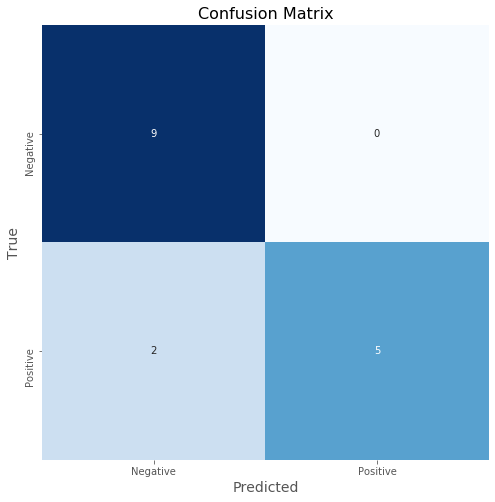

In [165]:
plt.figure(figsize = (8,8))
ax = plt.subplot()
sns.heatmap(cm, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('True', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### ROC Curve and AUC ROC

In [166]:
y_pred_proba = vc.predict_proba(X_test_sc)

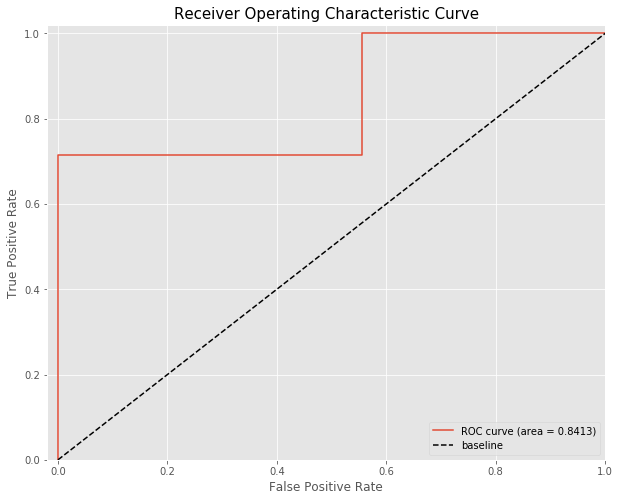

In [167]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)


# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend(loc="lower right");